#### Code for training and evaluating classification models (SVM, LR) on Report matcher data

###### Encodes the report text and metadata separately

###### contains training and inference pipeline. for Parameter tuning pipeline using train-dev sets, refer to "svm_rep_matcher_crossval"




In [34]:
import pickle

import sys
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt

import pandas as pd
from scipy import sparse
from scipy.sparse import hstack

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import os
sys.path.append("projects/report_matcher/qanda/")
import helperfactory.patientlevel_metrics as pat
from joblib import dump, load

from collections import Counter

In [35]:
path = "projects/report_matcher/qanda/train-test-data/latest/"

In [37]:
def printmsg(msg, printotconsole=True, logfilepath=""):
    if printotconsole:
        print(msg)
    if logfilepath != "":
        with open(logfilepath, "a") as text_file:
            text_file.write(msg)

In [38]:
def normalize_timegap(time_gap):
    if int(time_gap) >=30: #if np.round(int(time_gap)/30) >=1:
      time_gap_inmonths = str(int(np.round(int(time_gap)/30)))+ ' months'
    else:
      time_gap_inmonths = str(time_gap) + ' days'
    return time_gap_inmonths

In [39]:
#configure
encode_metadata_seperately = True

# Read data

In [ ]:
#consolidate (train, dev, test )_encoded_reports.pkl files and creates a list of objects.
#this should be part of init main

splits = ["Train", "Dev", "Test"]
indices_all =[]
for split in splits:
    input_file_path = path + f"{split}_encoded_reports.pkl"

    with open(input_file_path,"rb") as f:
        indices_all.extend(pickle.load(f))
len(indices_all)

In [40]:
'''
Given a list of patient Ids, this method reads the consolidated list of objects from (train,dev,test)_encoded_reports.pkl and returns the data for the patient IDs in a dictionary format for training and inference

INPUTS:
  index_ids: index ids or the patient ids from the cross val fold's

RETURNS:
  pairs:type dictionary
    contains the following format {key: value, ..} where 
    key = (round, index_ID, candidate_ID) and value = {"indtxt":.., "candtxt":.., "":.., "ind_modalityTC":.., ...., "timegap":..} all_report_texts, all_metadata, all_timegaps
  
  all_report_texts, all_metadata, all_timegaps: useful to create the vectorizer fit 
'''

def get_reports(index_ids):
  pairs = {}
  all_report_texts = []
  all_timegaps = []
  ind_metadata = []
  cand_metadata = []
    
  for p,ind in enumerate(indices_all):
    #skip if not in the crossval fold split
    if ind.key not in index_ids:
      continue

    #correct followup cand index
    location = ind.get_followup_location()

    indinfo = 'Modality: '+ ind.modalityQQ + '\n' + ind.txt.replace('\n', '').strip()
    if encode_metadata_seperately:
      indinfo = indinfo.strip()
    
    all_report_texts.append(indinfo)
    ind_metadata.append(ind.modalityQQ)

    for q,cand in enumerate(ind.candidates):
      if location == -1:
        task_lbl = 0 #change if 3 labels
      elif( location == q):
        task_lbl = 1
      else:
        task_lbl = 0
      assert(cand.label==task_lbl)
      
      candinfo = 'Modality: '+ cand.modalityQQ  + '\n Timegap: '+ normalize_timegap(cand.time_gap) + '\n' +  cand.txt.replace('\n', '').strip()
      if encode_metadata_seperately:
        candinfo = candinfo.strip()
                
      all_report_texts.append(candinfo)
      # all_report_texts.append(indinfo)
      cand_metadata.append(cand.modalityQQ)
      all_timegaps.append(normalize_timegap(cand.time_gap))

      element = {"indtxt": indinfo, "candtxt": candinfo, "label": task_lbl, 
                 "ind_modalityQQ": ind.modalityQQ, "cand_modalityQQ": cand.modalityQQ,
                 "ind_modalityTC": ind.modalityTC, "cand_modalityTC": cand.modalityTC, 
                 "timegap": normalize_timegap(cand.time_gap)}
                 
      pairs[(ind.round_key,ind.key, cand.key)]= element

  all_metadata = {"ind": ind_metadata, "cand": cand_metadata}
  return pairs, all_report_texts, all_metadata, all_timegaps

# Data encoding

##### Categories created based on Data analysis: Check "Data Analysis and categories" at the end of the notebook

In [41]:
#columns to append time gap information to the data
timegap_feat = ['same_day', "2-10_days", "11-20_days", "21-29_days"]
timegap_feat.extend([f"{str(x)}_months" for x in range(1, 17)])
len(timegap_feat)

20

In [42]:
#columns to append modality type information to the data
ind_modality_types = ['CT', 'MR']
cand_modality_types = ['CR', 'CT', 'DX', 'MG', 'MR', 'NM', 'OT', 'PT', 'RF', 'US', 'XA']
len(cand_modality_types)

11

In [43]:
'''
INPUTS:
  data: type dictionary
    should contain the following format {key: value, ..} where 
    key = (round, index_ID, candidate_ID) and value = {"indtxt":.., "candtxt":.., "":.., "ind_modalityTC":.., ...., "timegap":..}

  train_texts: Use to construct vocabulary for the TFIDF vector. fit method to encode indtxt and candtxt

  train_metadata: Use to construct vocabulary for the Binary vec. fit methods to encode modalityQQ

RETURNS:
  X_train, y_train: encoded data for inference

  vectorizer: fitted TFIDF vectorizer to encode indtxt and candtxt

  metadata_vectorizer: fitted Binary vectorizer to encode modalityQQ

  encoded_vec_colnames: list of the features. Useful for getting the feature importance scores
'''

def encode_train(data, train_texts, train_metadata, logfilepath="", normalize_case=False, append_token_binary_vec=False, reduce_feat=False, dim_cutoff_thresh = 1, encode_modality=True, encode_timegap= True, remove_stopwords=True, results_dir= ""):
  # printmsg(f"\nSample record: {train_texts[0]}", True, logfilepath)
  # Initialize TF-IDF representation
  encoded_vec_colnames = []
  if reduce_feat and remove_stopwords:
    vectorizer = TfidfVectorizer(min_df=dim_cutoff_thresh, stop_words='english')
  else:
    vectorizer = TfidfVectorizer()
  _ = vectorizer.fit_transform(train_texts)

  encoded_vec_colnames.extend(vectorizer.get_feature_names_out().tolist()) #index report vocab
  encoded_vec_colnames.extend(vectorizer.get_feature_names_out().tolist()) #candidate report vocab
  if append_token_binary_vec:
    encoded_vec_colnames.extend(vectorizer.get_feature_names_out().tolist()) #Binary 3V

  ind_metadata_vectorizer = CountVectorizer(binary = True)
  _ = ind_metadata_vectorizer.fit_transform(train_metadata["ind"])

  cand_metadata_vectorizer = CountVectorizer(binary = True)
  _ = cand_metadata_vectorizer.fit_transform(train_metadata["cand"])

  encoded_vec_colnames.extend(ind_modality_types)
  encoded_vec_colnames.extend(cand_modality_types)
  
  encoded_vec_colnames.extend(ind_metadata_vectorizer.get_feature_names_out().tolist()) #index metadata vocab
  encoded_vec_colnames.extend(cand_metadata_vectorizer.get_feature_names_out().tolist()) #candidate metadata vocab

  encoded_vec_colnames.extend(timegap_feat)

  X_train = []
  y_train = []

  train_cand_keys = []
  
  printmsg(f"\nlen of TFIDF vectorizer.vocabulary_ = {len(vectorizer.vocabulary_)}", True, logfilepath)
  printmsg(f"\nlen of index modality Binary vectorizer.vocabulary_ = {len(ind_metadata_vectorizer.vocabulary_)}", True, logfilepath)
  printmsg(f"\nlen of candidate modality Binary vectorizer.vocabulary_ = {len(cand_metadata_vectorizer.vocabulary_)}", True, logfilepath)

  # TF-IDF representation
  for key_info, val in data.items():
    ind_txt = val["indtxt"]
    cand_txt = val["candtxt"]
    train_cand_keys.append(key_info[2])

    if normalize_case:
      ind_vec = vectorizer.transform([ind_txt.lower()])
      cand_vec= vectorizer.transform([cand_txt.lower()])
    
    data_sample = hstack([ind_vec, cand_vec]).toarray()

    #Binary vectorizer for each word in the report. Creates additional columns eq to len of vocabulary
    if append_token_binary_vec:
      ind_search_space = ind_txt.lower()#.split()
      cand_search_space = cand_txt.lower()#.split()

      tok_searcher = []
      for i, tok in enumerate(vectorizer.get_feature_names_out().tolist()):
          if tok in ind_search_space and tok in cand_search_space:
            tok_searcher.append(1.0)
          else:
            tok_searcher.append(0.0)

      data_sample = hstack([data_sample, tok_searcher]).toarray()

    #encodes modality QQ and TC
    if encode_modality:
      #encode modality type. Firstly an array with zeros is created and then the correct modality type column is updated.
      ind_modalitytype_val = [0] * len(ind_modality_types)
      ind_modalitytype_val[ind_modality_types.index(val["ind_modalityTC"])] = 1

      cand_modalitytype_val = [0] * len(cand_modality_types)
      cand_modalitytype_val[cand_modality_types.index(val["cand_modalityTC"])] = 1

      # Binary vectorizer for index and cand modalities
      ind_meta_vec = ind_metadata_vectorizer.transform([val["ind_modalityQQ"]])
      # data_sample = hstack([data_sample, ind_meta_vec]).toarray()

      cand_meta_vec = cand_metadata_vectorizer.transform([val["cand_modalityQQ"]])
      data_sample = hstack([data_sample, ind_modalitytype_val, cand_modalitytype_val, ind_meta_vec, cand_meta_vec]).toarray()
    
    #Encodes timegap by buckets
    if encode_timegap:
      timegap_val = [0] * len(timegap_feat)
      c_timegap = val["timegap"]
      num, dm = c_timegap.split()
      if dm.strip() == "days":
          if int(num) == 1:
            timegap_val[timegap_feat.index("same_day")] = 1
          if int(num) >= 2 and int(num) <=10:
            timegap_val[timegap_feat.index("2-10_days")] = 1
          if int(num) >= 11 and int(num) <=20:
            timegap_val[timegap_feat.index("11-20_days")] = 1
          if int(num) >= 21 and int(num) <=29:
            timegap_val[timegap_feat.index("21-29_days")] = 1
      elif "month" in dm.strip():        
        timegap_val[timegap_feat.index(c_timegap.strip().replace(" ", "_"))] = 1
      
      data_sample = hstack([data_sample, timegap_val]).toarray()
      
    #add each row
    X_train.append(data_sample)
    y_train.append(val["label"]) 
  
  X_train = np.array(X_train)
  X_train = X_train.reshape(len(X_train), X_train[0].shape[1])
  printmsg(f"\ny_train distribution: {Counter(y_train)}", True, logfilepath)
  printmsg(f"\ntrain encoded vector size: {X_train.shape}",True, logfilepath)
  printmsg("\ntrain set encoding complete.", True, logfilepath)

  return X_train, y_train, vectorizer, {"ind": ind_metadata_vectorizer, "cand": cand_metadata_vectorizer}, encoded_vec_colnames, train_cand_keys

In [44]:
'''
INPUTS:
  data: type dictionary
    should contain the following format {key: value, ..} where 
    key = (round, index_ID, candidate_ID) and value = {"indtxt":.., "candtxt":.., "":.., "ind_modalityTC":.., ...., "timegap":..}

  vectorizer: TFIDF vec from train encoder. This is to encode the indtxt and candtxt

  metadata_vectorizer: Binary vec for the modalityQQ

RETURNS:
  X_dev, y_test: encoded data for inference

  test_rounds, test_index_keys, test_cand_keys: index, candidate IDs or keys useful to print results to a csv
'''

def encode_test(data, vectorizer, metadata_vectorizer, split_type="Test", logfilepath="", normalize_case=False, append_token_binary_vec=False, encode_modality=True, encode_timegap= True, results_dir= ""):
  X_test = []
  y_test = []
  test_rounds = []
  test_index_keys = []
  test_cand_keys = []

  # TF-IDF representation
  for key_info, val in data.items():
    ind_txt = val["indtxt"]
    cand_txt = val["candtxt"]

    if normalize_case:
      ind_vec = vectorizer.transform([ind_txt.lower()])
      cand_vec= vectorizer.transform([cand_txt.lower()])
    
    data_sample = hstack([ind_vec, cand_vec]).toarray()

    if append_token_binary_vec:
      ind_search_space = ind_txt.lower()#.split()
      cand_search_space = cand_txt.lower()#.split()

      tok_searcher = []
      for i, tok in enumerate(vectorizer.get_feature_names_out().tolist()):
          if tok in ind_search_space and tok in cand_search_space:
              tok_searcher.append(1.0)
          else:
              tok_searcher.append(0.0)

      data_sample = hstack([data_sample, tok_searcher]).toarray()
    
    #encodes modality QQ and TC
    if encode_modality:
      #encode modality type. Firstly an array with zeros is created and then the correct modality type column is updated.
      ind_modalitytype_val = [0] * len(ind_modality_types)
      ind_modalitytype_val[ind_modality_types.index(val["ind_modalityTC"])] = 1

      cand_modalitytype_val = [0] * len(cand_modality_types)
      cand_modalitytype_val[cand_modality_types.index(val["cand_modalityTC"])] = 1
      
      #Binary vectorizer for index and cand modalities
      ind_meta_vec = metadata_vectorizer["ind"].transform([val["ind_modalityQQ"]])
      # data_sample = hstack([data_sample, ind_meta_vec]).toarray()

      cand_meta_vec = metadata_vectorizer["cand"].transform([val["cand_modalityQQ"]])
      data_sample = hstack([data_sample, ind_modalitytype_val, cand_modalitytype_val, ind_meta_vec, cand_meta_vec]).toarray()
    
    #Encodes timegap by buckets
    if encode_timegap:
      timegap_val = [0] * len(timegap_feat)
      c_timegap = val["timegap"]
      num, dm = c_timegap.split()
      if dm.strip() == "days":
          if int(num) == 1:
            timegap_val[timegap_feat.index("same_day")] = 1
          if int(num) >= 2 and int(num) <=10:
            timegap_val[timegap_feat.index("2-10_days")] = 1
          if int(num) >= 11 and int(num) <=20:
            timegap_val[timegap_feat.index("11-20_days")] = 1
          if int(num) >= 21 and int(num) <=29:
            timegap_val[timegap_feat.index("21-29_days")] = 1
      elif "month" in dm.strip():        
        timegap_val[timegap_feat.index(c_timegap.strip().replace(" ", "_"))] = 1
      
      data_sample = hstack([data_sample, timegap_val]).toarray()

    X_test.append(data_sample)
    y_test.append(val['label'])
    test_rounds.append(key_info[0])
    test_index_keys.append(key_info[1])
    test_cand_keys.append(key_info[2])

  X_dev = np.array(X_test)
  X_dev = X_dev.reshape(len(X_dev), X_dev[0].shape[1])
  printmsg(f"\ny_{split_type} distribution {Counter(y_test)}", True, logfilepath)
  printmsg(f"\n{split_type} encoded vector size: {X_dev.shape}", True, logfilepath)
  printmsg(f"\n{split_type} set encoding complete.", True, logfilepath)

  return X_dev, y_test, test_rounds, test_index_keys, test_cand_keys

# Train - test

configuration

In [47]:

train_validate = False
train_test_flag = True

normalize_case = True

#append binary vectorizer
flag_3v = True

#reduce vocabulary
reduce_featureset = True
feature_cutoff_thresh = 100

#stopwords
remove_stopwords = True

model_selection = "logistic" #logistic or svm

sparse_or_dense = "dense"

debug = False

plot_fold_wise = False # to plot the threshold tunning results by fold
if train_validate:
    run_name = f"trainval_{model_selection}"
else:
    run_name = f"{model_selection}"
if reduce_featureset:
    run_name = run_name + f"_reduced{str(feature_cutoff_thresh)}"
if flag_3v:
    run_name = run_name + "_3V"
if sparse_or_dense == "sparce":
    run_name = run_name + "_" + sparse_or_dense
if debug:
    run_name = run_name + "_debug"
# run_name = run_name + "_bestparams"
if remove_stopwords:
    run_name = run_name + "_nostop"
# run_name = run_name + "_meta_timegap_encode_separately"
MAX_iter = 300
run_name = run_name + f"_maxiter{str(MAX_iter)}"
train_coef = {}

run_main_name = run_name
run_name = ""

In [48]:
print(run_main_name)

logistic_reduced100_3V_nostop_maxiter300


In [ ]:
model_random_seed = 51#seeds[1]
if model_selection == "svm":
    run_name = run_main_name + f"_seed{str(model_random_seed)}"
else:
    run_name = run_main_name

results_dir = f"projects/report_matcher/qanda/SVM/results_ft_maxiter/{run_name}/"

##############################################################################################

with open("projects/report_matcher/qanda/train-test-data/crossvalfolds.pkl", "rb") as fh:
    crossvalfolds = pickle.load(fh)

input_data = "projects/report_matcher/qanda/train-test-data/latest/indfulltext_candfulltext/full_data.csv"
full_input_data = pd.read_csv(input_data)


##############################################################################################

os.makedirs(results_dir, exist_ok=True)
os.makedirs(results_dir+"/dev/", exist_ok=True)
os.makedirs(results_dir+"/test/", exist_ok=True)
os.makedirs(results_dir+"/checkpoints/", exist_ok=True)

thresholdwise_scores_allfolds = []
thresholdwise_scores_allfolds_test = []

fold_ids = [0,1,2,3,4,0,1,2,3,4]
for i in range(5):
    printmsg(f"\n\n**************************** RUNNING FOLD {str(i)} ********************************", True, results_dir+ f"metrics_log.txt")
    
    train_fold = fold_ids[i:i+3]
    dev_fold = fold_ids[i+3]
    test_fold = fold_ids[i+4]

    printmsg(f"\ntrain = {train_fold}, dev = {dev_fold}, test = {test_fold}", True, results_dir+ f"metrics_log.txt")


    train_index_keys = crossvalfolds["split"+str(train_fold[0])] + crossvalfolds["split"+str(train_fold[1])] + crossvalfolds["split"+str(train_fold[2])]    
    val_index_keys = crossvalfolds["split"+str(dev_fold)]   
    test_index_keys = crossvalfolds["split"+str(test_fold)]

    parameters = [0.1] #[0.01, 0.1]
    params_score = {}
    max_f1 = 0
    bestthreshold = 0

    tuned_thresholds = []
    if train_validate:
        printmsg(f"\n\n**************************** RUNNING FOLD {str(i)} ********************************", False, results_dir+ f"metrics_log_dev.txt")
        train_input_pairs, all_report_texts, all_metadata, all_timegaps = get_reports(train_index_keys)         
        train_X, train_y, vectorizer, metadata_vectorizer, vec_features, train_row_ids = encode_train(train_input_pairs, all_report_texts, all_metadata, results_dir+ f"metrics_log_dev.txt", normalize_case, flag_3v, reduce_featureset, feature_cutoff_thresh, remove_stopwords, results_dir)
        
        val_input_data, _, _, _ = get_reports(val_index_keys)
        dev_X, dev_y, dev_rounds, dev_indx_keys, dev_cand_keys = encode_test(val_input_data, vectorizer, metadata_vectorizer, "dev", results_dir+ f"metrics_log_dev.txt", normalize_case, flag_3v, results_dir)

        if model_selection == "svm":
            chosen_param = 0.1
            model = svm.SVC(C=chosen_param ,class_weight='balanced', random_state=model_random_seed, kernel= 'sigmoid', probability=True, max_iter=MAX_iter)
            if sparse_or_dense == "sparce":
                train_X = sparse.csr_matrix(train_X)
            model.fit(train_X, train_y)
        
        if model_selection == "logistic":
            chosen_param = 0.1
            model = LogisticRegression(random_state=0, class_weight="balanced", solver='lbfgs', penalty="l2", C=0.1, max_iter=MAX_iter)
            if sparse_or_dense == "sparce":
                train_X = sparse.csr_matrix(train_X)
            model.fit(train_X, train_y)

            #this can be used to save svm coefs if using a linear kernal
            fold_num = f"fold_{str(i)}"
            train_coef[fold_num] = {"coef" : model.coef_,
                                    "vec": vectorizer,
                                    "metadata_vec": metadata_vectorizer,
                                    "vec_features": vec_features}

        #default predictions
        try:
            dev_predictions = model.predict(dev_X)
        except:
            dev_X = sparse.csr_matrix(dev_X)
            dev_predictions = model.predict(dev_X)
        predictions_list = dev_predictions.tolist()

        #class 1 predictions for threshold wise scoring.
        dev_predictions_prob = model.predict_proba(dev_X)
        class1_probs = dev_predictions_prob[:,1]
                    
        results = pd.DataFrame(list(zip(dev_rounds, dev_indx_keys, dev_cand_keys, dev_y, predictions_list)), columns=['round', 'index_key', 'cand_key', 'gt', 'pred'])
        results['prob'] = class1_probs

        scores, pat_scores_msg, _ = pat.get_patient_level_metrics(results, results_dir+"/dev/", results_dir+ f"metrics_log_dev.txt", "")
        printmsg(pat_scores_msg, True, results_dir+ f"metrics_log_dev.txt")


        #class 1 predictions for threshold wise scoring
        class1_preds = dev_predictions_prob[:,1]
        
        max_f1 = 0    
        dev_t_wise_score = {}        
        # thresholds = np.arange(0.1, 1.0, 0.05).tolist()
        if model_selection == "logistic":
            thresholds = [np.round(ti, 2) for ti in np.arange(0.1, 0.4, 0.05).tolist()]
            thresholds.extend([np.round(ti, 3) for ti in np.arange(0.425, 0.7, 0.025).tolist()])
            thresholds.extend([np.round(ti, 2) for ti in np.arange(0.7, 1.0, 0.05).tolist()])
        elif model_selection == "svm":
            thresholds = [np.round(ti, 3) for ti in np.arange(0.005, 0.1, 0.01).tolist()]
            thresholds.extend([np.round(ti, 2) for ti in np.arange(0.1, 1.0, 0.05).tolist()])
        
        for t in thresholds:
            predictions = (dev_predictions_prob[:,1] >= t).astype(int).tolist()                
            printmsg(f"\nProbability threshold {str(t)} - results:", True, results_dir+ f"metrics_log_dev.txt") #- classification report:\n{str(report)}
            results = pd.DataFrame(list(zip(dev_rounds, dev_indx_keys, dev_cand_keys, dev_y, predictions)), columns=['round', 'index_key', 'cand_key', 'gt', 'pred'])
            scores, pat_scores_msg, _ = pat.get_patient_level_metrics(results, results_dir+"/dev/", results_dir+ f"metrics_log_dev.txt", "")
            printmsg(pat_scores_msg + "\n", True, results_dir+ f"metrics_log_dev.txt")

            if scores['F1']>= max_f1:
                max_f1 = scores["F1"]
            
            dev_t_wise_score[t] = scores["F1"]

        for tr, sc in dev_t_wise_score.items():
            if sc == max_f1:
                tuned_thresholds.append(tr)
        
        printmsg(f"\n***** Best Probability thresholds on tuning {str(tuned_thresholds)} *****", True, results_dir+ f"metrics_log.txt")
    
    if train_test_flag:
        thresholdwise_scores = {}

        train_index_keys.extend(val_index_keys)

        train_input_pairs, all_report_texts, all_metadata, all_timegaps = get_reports(train_index_keys)         
        train_X, train_y, vectorizer, metadata_vectorizer, vec_features, train_row_ids = encode_train(train_input_pairs, all_report_texts, all_metadata, results_dir+ f"metrics_log.txt", normalize_case, flag_3v, reduce_featureset, feature_cutoff_thresh, remove_stopwords, results_dir)
        
        test_input_data, _, _, _ = get_reports(test_index_keys)
        test_X, test_y, test_rounds, test_indx_keys, test_cand_keys = encode_test(test_input_data, vectorizer, metadata_vectorizer, "test", results_dir+ f"metrics_log.txt", normalize_case, flag_3v, results_dir)

        if model_selection == "svm":
            chosen_param = 0.1
            model = svm.SVC(C=chosen_param ,class_weight='balanced', random_state=model_random_seed, kernel= 'sigmoid', probability=True, max_iter=MAX_iter)
            if sparse_or_dense == "sparce":
                train_X = sparse.csr_matrix(train_X)
            model.fit(train_X, train_y)
        
        if model_selection == "logistic":
            chosen_param = 0.1
            model = LogisticRegression(random_state=0, class_weight="balanced", solver='lbfgs', penalty="l2", C=0.1, max_iter=MAX_iter)
            if sparse_or_dense == "sparce":
                train_X = sparse.csr_matrix(train_X)
            model.fit(train_X, train_y)

            #this can be used to save svm coefs if using a linear kernal
            fold_num = f"fold_{str(i)}"
            train_coef[fold_num] = {"coef" : model.coef_,
                                    "vec": vectorizer,
                                    "metadata_vec": metadata_vectorizer,
                                    "vec_features": vec_features}

            with open(results_dir + "model_coefs.pkl", "wb") as f:
                pickle.dump(train_coef, f)       
        
        dump(model, results_dir+f"/checkpoints/fold{str(i)}.joblib") 

        #default predictions
        unique_save_name = f"test_fold{str(i)}__defpreds"
        try:
            test_predictions = model.predict(test_X)
        except:
            test_X = sparse.csr_matrix(test_X)
            test_predictions = model.predict(test_X)
        predictions_list = test_predictions.tolist()

        report = classification_report(test_y, test_predictions)
        printmsg(f"\nDefault predictions - classification report:\n{str(report)}", True, results_dir+ f"metrics_log.txt")

        #class 1 predictions for threshold wise scoring.
        test_predictions_prob = model.predict_proba(test_X)
        class1_probs = test_predictions_prob[:,1]
        
        
        results = pd.DataFrame(list(zip(test_rounds, test_indx_keys, test_cand_keys, test_y, predictions_list)), columns=['round', 'index_key', 'cand_key', 'gt', 'pred'])
        results['prob'] = class1_probs
        results.to_csv(f"{results_dir}/test/{unique_save_name}_predictions.csv")

        scores, pat_scores_msg, _ = pat.get_patient_level_metrics(results, results_dir+"/test/", results_dir+ f"metrics_log.txt", unique_save_name)
        printmsg(pat_scores_msg + "\n", True, results_dir+ f"metrics_log.txt")

        thresholdwise_scores['default'] = scores
        #class 1 predictions for threshold wise scoring
        class1_preds = test_predictions_prob[:,1]
        
        max_f1 = 0
        
        # thresholds = np.arange(0.1, 1.0, 0.05).tolist()
        if model_selection == "logistic":
            thresholds = [np.round(ti, 2) for ti in np.arange(0.1, 0.4, 0.05).tolist()]
            thresholds.extend([np.round(ti, 3) for ti in np.arange(0.425, 0.7, 0.025).tolist()])
            thresholds.extend([np.round(ti, 2) for ti in np.arange(0.7, 1.0, 0.05).tolist()])
        elif model_selection == "svm":
            thresholds = [np.round(ti, 3) for ti in np.arange(0.005, 0.1, 0.01).tolist()]
            thresholds.extend([np.round(ti, 2) for ti in np.arange(0.1, 1.0, 0.05).tolist()])
        
        if train_validate:
            for t in tuned_thresholds:
                unique_save_name = f"test_fold{str(i)}__THRESH{t}"
                predictions = (test_predictions_prob[:,1] >= t).astype(int).tolist()
                report = classification_report(test_y, predictions)
                printmsg(f"\nProbability threshold {str(t)} - results:", False, results_dir+ f"metrics_log.txt") #- classification report:\n{str(report)}
                results = pd.DataFrame(list(zip(test_rounds, test_indx_keys, test_cand_keys, test_y, predictions)), columns=['round', 'index_key', 'cand_key', 'gt', 'pred'])
                results.to_csv(f"{results_dir}/test/{unique_save_name}_predictions.csv")

                scores, pat_scores_msg, _ = pat.get_patient_level_metrics(results, results_dir+"/test/", results_dir+ f"metrics_log.txt", unique_save_name)
                printmsg(pat_scores_msg + "\n", True, results_dir+ f"metrics_log.txt")

                thresholdwise_scores[t] = scores                

                if scores['F1']> max_f1:
                    best_run = unique_save_name
                    bestthreshold = t
                    max_f1 = scores['F1']
                    best_report = report


        else:
            for t in thresholds:
                unique_save_name = f"test_fold{str(i)}__THRESH{t}"
                predictions = (test_predictions_prob[:,1] >= t).astype(int).tolist()
                report = classification_report(test_y, predictions)
                printmsg(f"\nProbability threshold {str(t)} - results:", False, results_dir+ f"metrics_log.txt") #- classification report:\n{str(report)}
                results = pd.DataFrame(list(zip(test_rounds, test_indx_keys, test_cand_keys, test_y, predictions)), columns=['round', 'index_key', 'cand_key', 'gt', 'pred'])
                results.to_csv(f"{results_dir}/test/{unique_save_name}_predictions.csv")

                scores, pat_scores_msg, _ = pat.get_patient_level_metrics(results, results_dir+"/test/", results_dir+ f"metrics_log.txt", unique_save_name)
                printmsg(pat_scores_msg + "\n", True, results_dir+ f"metrics_log.txt")

                thresholdwise_scores[t] = scores                

                if scores['F1']> max_f1:
                    best_run = unique_save_name
                    bestthreshold = t
                    max_f1 = scores['F1']
                    best_report = report
            
            thresholdwise_scores_allfolds_test.append(thresholdwise_scores)

        if plot_fold_wise:   
            # Extracting the threshold values, precision (p), recall (r), and F1 scores (f1)
            thresholds = [float(key) for key in thresholdwise_scores.keys()]
            precision = [thresholdwise_scores[key]['P'] for key in thresholdwise_scores.keys()]
            recall = [thresholdwise_scores[key]['R'] for key in thresholdwise_scores.keys()]
            f1_score = [thresholdwise_scores[key]['F1'] for key in thresholdwise_scores.keys()]
            
            # Plotting
            plt.figure(figsize=(15, 6))
            plt.plot(thresholds, precision, label='Precision', marker='o')
            plt.plot(thresholds, recall, label='Recall', marker='s')
            plt.plot(thresholds, f1_score, label='F1 Score', marker='^')

            # Adding data point labels
            # for (ix, txt) in enumerate(precision):
            #     plt.annotate(f"{txt:.2f}", (thresholds[ix], precision[ix]), textcoords="offset points", xytext=(0,10), ha='center')
            # for (ix, txt) in enumerate(recall):
            #     plt.annotate(f"{txt:.2f}", (thresholds[ix], recall[ix]), textcoords="offset points", xytext=(0,10), ha='center')
            for (ix, txt) in enumerate(f1_score):
                plt.annotate(f"{txt:.2f}", (thresholds[ix], f1_score[ix]), textcoords="offset points", xytext=(0,10), ha='center')

            plt.xlabel('Threshold')
            plt.ylabel('Score')
            plt.xticks(thresholds, rotation="vertical")
            plt.title(f'Test - Fold {str(i)} - Performance Evaluation at Various Thresholds')
            plt.legend()
            plt.grid(True)
            plt.show()
            
        printmsg(f"\nBest F1 {str(max_f1)} for {best_run} threshold = {str(bestthreshold)} \n classification report \n\t {best_report}", True, results_dir+ f"metrics_log.txt")
    
        printmsg(f"\nCompleted evaluating for the fold", True, results_dir+ f"metrics_log.txt")
        
        if debug:
            break

# if model_selection == "logistic":
#     break #Remove this in case if case of a solver that supports the random state parameter


# Threshold tuning

#### Find the best threshold Fold wise

In [76]:
fold_wise_f1s = pd.read_csv("projects/report_matcher/qanda/SVM/lrsvm_scoretemp.csv")
fold_wise_f1s = fold_wise_f1s.fillna(0)
fold_wise_f1s['best threshold'] = ''
fold_wise_f1s.index = fold_wise_f1s['Fold']
fold_wise_f1s = fold_wise_f1s.drop('Fold', axis=1)

In [77]:
t_overall_f1= pd.DataFrame(0.0, index=thresholds,columns=['F1', 'rank'])

best_foldwise_t_f1 = {}

for f_i, fold_scores in enumerate(thresholdwise_scores_allfolds_test):
    max_F1_perfold = 0.0
    best_fold_t = ''
    best_scores = {}
    for t, scores in fold_scores.items():
        if t == "default":
            continue
        if scores['F1'] >= max_F1_perfold:
            max_F1_perfold = scores['F1']
            best_scores = scores
            best_fold_t = str(t)

    ## to account for more than one threshold with the same max F1
    # for t, scores in fold_scores.items():
    #     if scores['F1'] == max_F1_perfold:
    #         if best_fold_t != "":
    #             best_fold_t += f", {t}"
    #         else:
    #             best_fold_t = f"{t}"
    
    fold_wise_f1s.loc[f"Fold {str(f_i+1)}", 'best threshold'] = best_fold_t

    for col in ['TP', 'FP', 'TN', 'FN', 'P', 'R', 'F1']:
        fold_wise_f1s.loc[f"Fold {str(f_i+1)}", col] = best_scores[col]

for col in ['TP', 'FP', 'TN', 'FN']:
    fold_wise_f1s.loc['Total', col] = fold_wise_f1s[col].sum()

fold_wise_f1s.loc['Total', 'P'] = np.round(fold_wise_f1s.loc['Total','TP']/ (fold_wise_f1s.loc['Total','TP'] + fold_wise_f1s.loc['Total','FP']), 3)
fold_wise_f1s.loc['Total', 'R'] = np.round(fold_wise_f1s.loc['Total','TP']/ (fold_wise_f1s.loc['Total','TP'] + fold_wise_f1s.loc['Total','FN']), 3)
fold_wise_f1s.loc['Total', 'F1'] = np.round((2 * fold_wise_f1s.loc['Total','P'] * fold_wise_f1s.loc['Total','R']) / (fold_wise_f1s.loc['Total','P'] + fold_wise_f1s.loc['Total','R']), 3)
fold_wise_f1s['Count'] = fold_wise_f1s['TP'] + fold_wise_f1s['FP'] + fold_wise_f1s['TN'] + fold_wise_f1s['FN']

for col in ['TP', 'FP', 'TN', 'FN', 'Count']:
    fold_wise_f1s[col] = fold_wise_f1s[col].astype(int) 

fold_wise_f1s

,TP,FP,TN,FN,P,R,F1,Count,best threshold
Fold,,,,,,,,,
Fold 1,57,19,9,21,0.750,0.731,0.740,106,0.045
Fold 2,61,14,12,18,0.813,0.772,0.792,105,0.055
Fold 3,58,19,15,13,0.753,0.817,0.784,105,0.085
Fold 4,54,23,12,16,0.701,0.771,0.735,105,0.075
Fold 5,66,15,11,13,0.815,0.835,0.825,105,0.055
Total,296,90,59,81,0.767,0.785,0.776,526,


In [78]:
os.makedirs(results_dir + "threshold_scores/", exist_ok=True)
fold_wise_f1s.to_csv(results_dir + "threshold_scores/" + "fold_best_threshold.csv")

#### Find overall F1 scores for each threshold and tag the top ones

In [79]:
t_overall_f1= pd.DataFrame(0.0, index=thresholds + ['default'], columns=['F1', 'rank'])
t_overall_f1['rank'] = ''
max_F1t_overall = 0.0
best_overall_t = 0
for t in thresholds + ['default']:
    TP = 0
    FP = 0
    FN = 0

    for f_t in thresholdwise_scores_allfolds_test:
        TP += f_t[t]['TP']
        FP += f_t[t]['FP']
        FN += f_t[t]['FN']

    Precision = TP/(TP+FP) if TP+FP > 0 else 0    
    Recall = TP/(TP+FN) if TP+FN > 0 else 0    
    F1_t = 2*Precision*Recall/(Precision + Recall) if Precision + Recall > 0 else 0  

    Precision = np.round(Precision, 3)
    Recall = np.round(Recall, 3)
    F1_t = np.round(F1_t, 3)

    if F1_t >= max_F1t_overall:
        max_F1t_overall = F1_t
        best_overall_t = t

    t_overall_f1.loc[t, 'F1'] = F1_t
print(f"best threshold across all folds = {best_overall_t} with F1 = {max_F1t_overall}")

best threshold across all folds = 0.055 with F1 = 0.77


In [80]:
#mark all the thresholds where the corrsponding F1 eq to max threshold obtained above
t_overall_f1.loc[t_overall_f1['F1']==max_F1t_overall, 'rank'] = 'top'
os.makedirs(results_dir + "threshold_scores/", exist_ok=True)
t_overall_f1 = t_overall_f1.sort_values(by='F1', ascending=False)
t_overall_f1.to_csv(results_dir + "threshold_scores/" + "overall_f1bythresh.csv")
t_overall_f1.head(10)

,F1,rank
0.055,0.770,top
default,0.762,
0.065,0.759,
0.045,0.755,
0.075,0.755,
0.085,0.747,
0.095,0.729,
0.1,0.720,
0.035,0.709,
0.025,0.633,


#### save the scores corresponding to the best overall threshold to a csv file 

In [81]:
best_overall_t = t_overall_f1[t_overall_f1['F1']==max_F1t_overall].index.to_list()
best_overall_t

[0.055]

In [82]:
overall_scores_bestt = pd.DataFrame()
for t in best_overall_t:
   best_t_scores = []
   totals_row = {'TP': 0, 'FP':0, 'TN':0, 'FN':0}
   for f_t in thresholdwise_scores_allfolds_test:
      best_t_scores.append(f_t[t])
      print(f_t[t])

      for c in ['TP', 'FP', 'TN', 'FN']:
         totals_row[c] += f_t[t][c]

   totals_row['P'] = np.round(totals_row['TP']/(totals_row['TP']+totals_row['FP']), 3)
   totals_row['R'] = np.round(totals_row['TP']/(totals_row['TP']+totals_row['FN']), 3)
   totals_row['F1'] = np.round((2 * totals_row['P'] * totals_row['R'])/(totals_row['P'] + totals_row['R']), 3)
   best_t_scores.append(totals_row)
   
   df = pd.DataFrame(best_t_scores)
   df['threshold'] = t
   overall_scores_bestt = pd.concat([overall_scores_bestt, df])

overall_scores_bestt.to_csv(results_dir + "threshold_scores/" + "overall_bestthresh_scores.csv")
overall_scores_bestt

{'TP': 55, 'FP': 18, 'TN': 10, 'FN': 23, 'P': 0.753, 'R': 0.705, 'F1': 0.728}
{'TP': 61, 'FP': 14, 'TN': 12, 'FN': 18, 'P': 0.813, 'R': 0.772, 'F1': 0.792}
{'TP': 59, 'FP': 21, 'TN': 13, 'FN': 12, 'P': 0.738, 'R': 0.831, 'F1': 0.781}
{'TP': 53, 'FP': 25, 'TN': 10, 'FN': 17, 'P': 0.679, 'R': 0.757, 'F1': 0.716}
{'TP': 66, 'FP': 15, 'TN': 11, 'FN': 13, 'P': 0.815, 'R': 0.835, 'F1': 0.825}


,TP,FP,TN,FN,P,R,F1,threshold
0,55,18,10,23,0.753,0.705,0.728,0.055
1,61,14,12,18,0.813,0.772,0.792,0.055
2,59,21,13,12,0.738,0.831,0.781,0.055
3,53,25,10,17,0.679,0.757,0.716,0.055
4,66,15,11,13,0.815,0.835,0.825,0.055
5,294,93,56,83,0.760,0.780,0.770,0.055


# Feature importance analysis for every fold

In [49]:
#write aditional columns that are newly added to valiate manually
checkdata = pd.DataFrame(train_X[:, len(vectorizer.vocabulary_)*2:], columns=vec_features[len(vectorizer.vocabulary_)*2:])
checkdata["index"] = train_row_ids
checkdata.to_csv(results_dir+"addl_cols_train_data.csv")

In [76]:
# with open(results_dir + "model_coefs.pkl", "rb") as f:
#     train_coef = pickle.load(f)
train_coef

{'fold_0': {'coef': array([[-0.01376336,  0.00719221,  0.        , ..., -0.43074711,
          -0.68591631, -0.44578807]]),
  'vec': TfidfVectorizer(min_df=10, stop_words='english'),
  'metadata_vec': {'ind': CountVectorizer(binary=True),
   'cand': CountVectorizer(binary=True)},
  'vec_features': ['00',
   '01',
   '018',
   '02',
   '03',
   '035',
   '04',
   '05',
   '06',
   '07',
   '08',
   '09',
   '10',
   '100',
   '1001',
   '100cc',
   '101',
   '102',
   '103',
   '104',
   '105',
   '106',
   '107',
   '108',
   '109',
   '10am',
   '10th',
   '11',
   '110',
   '1101',
   '111',
   '112',
   '113',
   '114',
   '115',
   '116',
   '117',
   '118',
   '119',
   '11th',
   '12',
   '120',
   '1201',
   '121',
   '122',
   '123',
   '124',
   '125',
   '126',
   '127',
   '128',
   '129',
   '13',
   '130',
   '131',
   '132',
   '133',
   '134',
   '135',
   '136',
   '137',
   '138',
   '139',
   '14',
   '140',
   '141',
   '142',
   '143',
   '144',
   '145',
   '146',


In [15]:
for i in range(5):
    encoded_vec_type = []

    foldid = "fold_" + str(i)
    
    feature_names = train_coef[foldid]['vec_features']
    print("feature_names  len = ", len(feature_names))
    
    tfidf_vocab_len = len(train_coef[foldid]['vec'].get_feature_names_out().tolist())

    encoded_vec_type.extend(["ind_text"] * tfidf_vocab_len)

    encoded_vec_type.extend(["cand_text"] * tfidf_vocab_len)

    if flag_3v:
        encoded_vec_type.extend(["3V"] * tfidf_vocab_len)
    
    encoded_vec_type.extend(["ind_modalityTC"] * len(ind_modality_types))
    encoded_vec_type.extend(["cand_modalityTC"] * len(cand_modality_types))
    encoded_vec_type.extend(["ind_modalityQQ"] * len(train_coef[foldid]['metadata_vec']['ind'].get_feature_names_out().tolist()))
    encoded_vec_type.extend(["cand_modalityQQ"] * len(train_coef[foldid]['metadata_vec']['cand'].get_feature_names_out().tolist()))
    encoded_vec_type.extend(["timegap"] * len(timegap_feat))

    coefficients = train_coef[foldid]['coef'].flatten()
    print("coefficients len = ", len(coefficients))

    assert(len(coefficients)==len(feature_names))

    assert(len(coefficients)==len(encoded_vec_type))

    pd.DataFrame(list(zip(encoded_vec_type, feature_names, coefficients.tolist())), columns = ["type", "word", "coef"]).to_csv(results_dir+f"{foldid}_coefs.csv")

feature_names  len =  2532
coefficients len =  2532
feature_names  len =  2527
coefficients len =  2527
feature_names  len =  2536
coefficients len =  2536
feature_names  len =  2503
coefficients len =  2503
feature_names  len =  2491
coefficients len =  2491


#### Important features from index text

In [52]:
index_coefs = coefficients[:tfidf_vocab_len]
index_feats = feature_names[:tfidf_vocab_len]
print(index_feats[0])
print(index_feats[-1])
print(feature_names[tfidf_vocab_len])

00
yet
00


##### positive

In [53]:
ind_feature_importance = dict(zip(index_feats, index_coefs))
top10 = sorted(ind_feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
for f in top10:
    print(f)

('is', 0.29846916337332496)
('up', 0.2915154041873049)
('follow', 0.2904903510744422)
('breast', 0.259899813475518)
('nodule', 0.2558674092124675)
('normal', 0.25491158514331863)
('adrenal', 0.23802526659541673)
('risk', 0.22301930101839507)
('aortic', 0.2058094078356765)
('hernia', 0.20227282734223873)


##### negative

In [54]:
ind_feature_importance = dict(zip(index_feats, index_coefs))
top10 = sorted(ind_feature_importance.items(), key=lambda x: x[1], reverse=False)[:10]
for f in top10:
    print(f)

('11', -0.2534717588711209)
('301', -0.2517742396133149)
('contrast', -0.229019126249147)
('collection', -0.22096600151784598)
('defined', -0.21823120224245338)
('in', -0.20838442738583485)
('ill', -0.20660889743898625)
('image', -0.193024695695429)
('cell', -0.19011494455543498)
('terminates', -0.1884416556219611)


#### Important features from candidate text

In [55]:
cand_feats = feature_names[tfidf_vocab_len:tfidf_vocab_len*2]
cand_coefs = coefficients[tfidf_vocab_len:tfidf_vocab_len*2]
print(cand_feats[0])
print(cand_feats[-1])
print(feature_names[tfidf_vocab_len*2])

00
yet
CT


In [56]:
cand_feature_importance = dict(zip(cand_feats, cand_coefs))
top10 = sorted(cand_feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
for f in top10:
    print(f)

('nodule', 1.1878197368827825)
('nodules', 0.7554729152163159)
('lobe', 0.7406017128456049)
('mm', 0.5663603411037124)
('seen', 0.5573548984980121)
('upper', 0.5430690948442944)
('ct', 0.47980431530978085)
('pulmonary', 0.4676711389920062)
('hepatic', 0.4409002738462008)
('resolution', 0.3965439342817228)


In [57]:
cand_feature_importance = dict(zip(cand_feats, cand_coefs))
top10 = sorted(cand_feature_importance.items(), key=lambda x: x[1], reverse=False)[:10]
for f in top10:
    print(f)

('catheter', -0.3889555564836973)
('brain', -0.3495076579633478)
('ventricles', -0.3011644754074005)
('vein', -0.2988082219308382)
('hemorrhage', -0.29267717624589973)
('acute', -0.2911130206640437)
('cm', -0.2796352238673703)
('spine', -0.27053600144974477)
('extra', -0.26619003129584956)
('similar', -0.26517218010437527)


#### Important features from modality type

##### index

In [58]:
prev_index = tfidf_vocab_len*2
feats = feature_names[prev_index:prev_index+len(ind_modality_types)]
coefs = coefficients[prev_index:prev_index+len(ind_modality_types)]
print(feats[0])
print(feats[-1])
prev_index += len(ind_modality_types)
print(feature_names[prev_index])

CT
MR
CR


In [59]:
ftimp = dict(zip(feats, coefs))
top10 = sorted(ftimp.items(), key=lambda x: x[1], reverse=True)[:10]
for f in top10:
    print(f)

('CT', 0.02530200560306208)
('MR', -0.025244357230492225)


##### candidate

In [60]:
curr_index = prev_index + len(cand_modality_types)
feats = feature_names[prev_index:curr_index]
coefs = coefficients[prev_index:curr_index]
print(feats[0])
print(feats[-1])
print(feature_names[curr_index])
prev_index = curr_index

CR
XA
abdomen


In [61]:
ftimp = dict(zip(feats, coefs))
top10 = sorted(ftimp.items(), key=lambda x: x[1], reverse=True)[:10]
for f in top10:
    print(f)

('PT', 0.3757268624833237)
('RF', 0.36668509359123896)
('MR', 0.3041770298743296)
('US', 0.23834039338340318)
('MG', 0.17509824502425586)
('CT', 0.14954149617992785)
('NM', 0.13268425177317697)
('DX', -0.016979168132857405)
('OT', -0.03685805411834275)
('XA', -0.4372503517852817)


#### Important features from modality QQ

##### index

In [62]:
curr_index = prev_index + len(train_coef[foldid]['metadata_vec']['ind'].get_feature_names_out().tolist())
feats = feature_names[prev_index:curr_index]
coefs = coefficients[prev_index:curr_index]
print(feats[0])
print(feats[-1])
print(feature_names[curr_index])
prev_index = curr_index

abdomen
wwo
177


In [63]:
ftimp = dict(zip(feats, coefs))
top10 = sorted(ftimp.items(), key=lambda x: x[1], reverse=True)[:10]
for f in top10:
    print(f)

('pe', 0.3804373831797823)
('cont', 0.36007259418420845)
('with', 0.33296628680942414)
('kub', 0.2304680801534731)
('protocol', 0.2304680801534731)
('lung', 0.19471041126047314)
('needle', 0.10060888954390604)
('bx', 0.100608889543906)
('cancer', 0.09731664392496821)
('iron', 0.09422572320548919)


##### candidate

In [64]:
curr_index = prev_index + len(train_coef[foldid]['metadata_vec']['cand'].get_feature_names_out().tolist())
feats = feature_names[prev_index:curr_index]
coefs = coefficients[prev_index:curr_index]
print(feats[0])
print(feats[-1])
print(feature_names[curr_index])
prev_index = curr_index

177
y90
same_day


In [65]:
ftimp = dict(zip(feats, coefs))
top10 = sorted(ftimp.items(), key=lambda x: x[1], reverse=True)[:10]
for f in top10:
    print(f)

('chest', 1.105832905188529)
('wo', 0.7856019737972652)
('abdomen', 0.5664575214226576)
('needle', 0.5565349647808095)
('body', 0.48363596318663504)
('lung', 0.45454132227274996)
('upper', 0.44196648082695866)
('limited', 0.4227164341700124)
('ct', 0.42259628803471594)
('bone', 0.4182973651619953)


#### Important features from timegap

In [66]:
curr_index = prev_index + len(timegap_feat)
feats = feature_names[prev_index:curr_index]
coefs = coefficients[prev_index:curr_index]
print(feats[0])
print(feats[-1])
print(feature_names[-1])
prev_index = curr_index

same_day
16_months
16_months


In [67]:
ftimp = dict(zip(feats, coefs))
top10 = sorted(ftimp.items(), key=lambda x: x[1], reverse=True)
for f in top10:
    print(f)

('same_day', 1.6068542093485503)
('11-20_days', 1.3741260357653289)
('2-10_days', 1.1985016937665691)
('21-29_days', 1.1509700744706084)
('3_months', 0.9418116949165221)
('2_months', 0.6554677846094987)
('1_months', 0.649535020567511)
('4_months', 0.1965468263827705)
('6_months', 0.10393451574022068)
('5_months', -0.19061883245665118)
('7_months', -0.27489778147765015)
('14_months', -0.46730879126653246)
('11_months', -0.716442113751008)
('12_months', -0.7391322634057392)
('10_months', -0.779829640333881)
('8_months', -0.7901082146729811)
('16_months', -0.8128695330365744)
('9_months', -0.8670149004112084)
('13_months', -0.9957260952571125)
('15_months', -1.24374204112567)


In [68]:
# encoded_vec_type.extend(["ind_modalityTC"] * len(ind_modality_types))
# encoded_vec_type.extend(["cand_modalityTC"] * len(cand_modality_types))
# encoded_vec_type.extend(["ind_modalityQQ"] * len(train_coef[foldid]['metadata_vec']['ind'].get_feature_names_out().tolist()))
# encoded_vec_type.extend(["cand_modalityQQ"] * len(train_coef[foldid]['metadata_vec']['cand'].get_feature_names_out().tolist()))
# encoded_vec_type.extend(["timegap"] * len(timegap_feat))

# Data Analysis and categories

In [14]:
pairs = {}
all_report_texts = []
all_report_textplusmetadata = []

all_report_textplusmetadata_pairs = []

norm_timegaps = []
timegaps = []
ind_modqq = []
cand_modqq = []

ind_modtc = []
cand_modtc = []

for p,ind in enumerate(indices_all):
    #correct followup cand index
    location = ind.get_followup_location()

    indinfo = 'Modality: '+ ind.modalityQQ + '\n' + ind.txt.replace('\n', '').strip()
    indinfo = indinfo.strip()
    
    all_report_texts.append(ind.txt.replace('\n', '').strip())
    all_report_textplusmetadata.append(indinfo)

    ind_modqq.append(ind.modalityQQ)
    ind_modtc.append(ind.modalityTC)

    # if ind.modalityTC not in ind.modalityQQ:
    #   print(f"ind TC = {ind.modalityTC}, QQ= {ind.modalityQQ}")

    for q,cand in enumerate(ind.candidates):
        if location == -1:
          task_lbl = 0 #change if 3 labels
        elif( location == q):
          task_lbl = 1
        else:
          task_lbl = 0
        
        assert(cand.label==task_lbl)

        if cand.key == "round13_Sample_328_04":
           print(f"{task_lbl}, {cand.label}") 
        norm_timegaps.append(normalize_timegap(cand.time_gap))
        timegaps.append(int(cand.time_gap))
        candinfo = 'Modality: '+ cand.modalityQQ  + '\n Timegap: '+ normalize_timegap(cand.time_gap) + '\n' +  cand.txt.replace('\n', '').strip()
        candinfo = candinfo.strip()
        
        all_report_texts.append(cand.txt.replace('\n', '').strip())
        all_report_textplusmetadata.append(candinfo)

        all_report_textplusmetadata_pairs.append(indinfo)
        all_report_textplusmetadata_pairs.append(candinfo)

        cand_modqq.append(cand.modalityQQ)
        cand_modtc.append(cand.modalityTC)

        # if cand.modalityTC not in cand.modalityQQ:
        #   print(f"cand TC = {cand.modalityTC}, QQ= {cand.modalityQQ}")

        element = (indinfo.strip(),candinfo.strip(),task_lbl)
        pairs[(ind.round_key,ind.key, cand.key)]= element
    

0, 0


In [15]:
print(Counter(ind_modtc))
print(Counter(cand_modtc))

Counter({'CT': 543, 'MR': 43})
Counter({'CR': 2139, 'CT': 2003, 'MR': 520, 'US': 516, 'NM': 171, 'RF': 150, 'XA': 127, 'PT': 99, 'MG': 65, 'OT': 12, 'DX': 5})


In [66]:
sorted(dict(Counter(list(cand_modqq))).items(), key=lambda item: item[1], reverse=True)

[('CT CHEST WO CONT', 143),
 ('CT CHEST ABDOMEN AND PELVIS W CONTRAST', 115),
 ('CT CHEST WO CONTRAST', 82),
 ('CT ABDOMEN AND PELVIS W CONTRAST', 39),
 ('CT CHEST PE WITH CONTRAST', 30),
 ('CT CHEST WITH CONTRAST', 29),
 ('CT CHEST W CONT', 28),
 ('MRI ABDOMEN WO/W CONTRAST', 27),
 ('CT ABDOMEN W CONTRAST', 8),
 ('CTA CHEST ANGIO', 6),
 ('CT ABDOMEN AND PELVIS WO CONT', 6),
 ('MRI ABDOMEN WITHOUT CONTRAST', 6),
 ('CTA ABDOMEN AND PELVIS ANGIO', 5),
 ('CT NECK SOFT TISSUE WITH CONT', 4),
 ('CT CHEST WO/W CONTRAST', 3),
 ('CT KUB PROTOCOL', 3),
 ('CTA CHEST AND CT ABDOMEN AND PELVIS W CONT', 3),
 ('CT T SPINE WO CONT', 2),
 ('CT NECK SOFT TISS W CONT', 2),
 ('CT LUNG CANCER SCREENING', 2),
 ('CT C SPINE WO CONT', 2),
 ('CT Chest WO Cont', 2),
 ('CT CHEST ABDOMEN AND PELVIS WO CONTRAST', 2),
 ('MRI L SPINE WO CONT', 2),
 ('CT ABDOMEN WO/W CONTRAST', 2),
 ('MRI ABDOMEN WO CONT', 2),
 ('CTA CHEST ABDOMEN PELVIS ANGIO', 2),
 ('*SCHED AT UM* CT IVP', 1),
 ('CT CHEST ABDOMEN AND PELVIS WO/W  

In [65]:
sorted(dict(Counter(list(all_cand_mod))).items(), key=lambda item: item[1], reverse=True)

[('XR CHEST 2 VIEWS', 608),
 ('XR CHEST 1VIEW', 543),
 ('CT CHEST ABDOMEN AND PELVIS W CONTRAST', 454),
 ('XR CHEST 1 VIEW', 260),
 ('CT CHEST WO CONTRAST', 239),
 ('CT CHEST WO CONT', 232),
 ('XR ABDOMEN 1 VIEW', 206),
 ('CT HEAD WO CONT', 175),
 ('CT ABDOMEN AND PELVIS W CONTRAST', 126),
 ('MRI BRAIN WO/W CONT', 101),
 ('MRI ABDOMEN WO/W CONTRAST', 96),
 ('CT CHEST WITH CONTRAST', 92),
 ('CT NECK SOFT TISSUE WITH CONT', 74),
 ('PET CT MID BODY', 61),
 ('NM BONE SCAN TOTAL BODY', 60),
 ('DEXA, AXIAL SKELETON', 60),
 ('CT CHEST PE WITH CONTRAST', 57),
 ('US LOW EXT BILAT VENOUS DPLX', 57),
 ('CT CHEST W CONT', 54),
 ('US ABDOMEN LIMITED', 46),
 ('US ABDOMINAL PARACENTESIS', 43),
 ('XR L SPINE 2-3 VIEWS', 41),
 ('CT NECK SOFT TISS W CONT', 40),
 ('MRI BRAIN WO/W CONTRAST', 39),
 ('CT LUNG NEEDLE BX', 33),
 ('XR ERCP CATH BIL PAN DUCT', 32),
 ('US RETROPERITONEAL COMPLETE', 29),
 ('CT THERAPY PLAN RAD ONC BODY', 28),
 ('US LIVER BX PERC NEEDLE W RAD', 27),
 ('CT THERAPY PLAN RAD ONC NEUR

In [57]:
len(np.unique(all_ind_mod))

56

In [58]:
[x for x in list(np.unique(all_ind_mod)) if x not in list(np.unique(all_cand_mod))]

['*SCHED AT UM* CT IVP',
 'CT ABDOMEN AND PELVIS W CONT',
 'CT Chest And Abdomen W Cont',
 'CT Lung Low Dose Screening',
 'CT SHOULDER LEFT W CONTRAST',
 'CT TX PLANNING RAD ONC',
 'CTA AORTA',
 'MRI CARDIAC WITH CONTRAST FOR CARDIOMYOPATHY, ARVD, VIABILITY, PERICARDIAL',
 'MRI CHEST WO CONT']

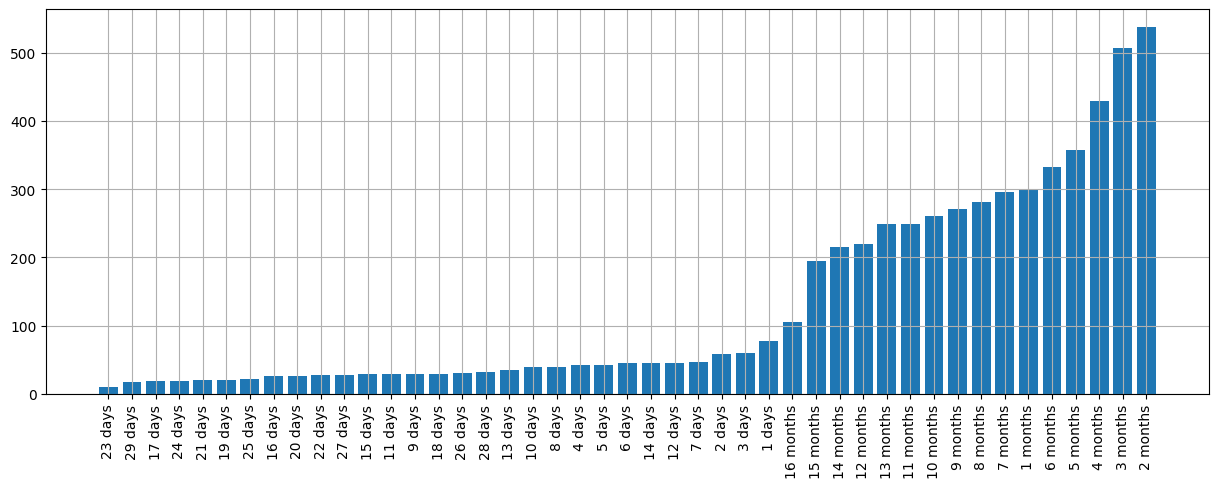

In [48]:
from collections import Counter

norm_timegaps_freq = dict(Counter(norm_timegaps))

#sort by num days
# norm_timegaps_freq = {k: v for k, v in sorted(norm_timegaps_freq.items(), key=lambda item: item[0])}

#sort by frequency
norm_timegaps_freq = {k: v for k, v in sorted(norm_timegaps_freq.items(), key=lambda item: item[1])}


labels = [k for k, v in norm_timegaps_freq.items()]
values = [v for k, v in norm_timegaps_freq.items()]
plt.figure(figsize=(15, 5))
plt.bar(labels, values)
plt.grid("major")
plt.xticks(labels, rotation='vertical')
plt.show()

In [50]:
len([x for x in labels if "days" in x])

29